In [1]:
import matplotlib.pyplot as plt
import pickle, gzip
import numpy as np
import copy

import sys
sys.path.append('../src')

import neuralnetworkclassifier as nnc
import mlutils as ml

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
!wget http://deeplearning.net/data/mnist/mnist.pkl.gz

--2019-11-12 07:59:06--  http://deeplearning.net/data/mnist/mnist.pkl.gz
Resolving deeplearning.net (deeplearning.net)... 132.204.26.28
Connecting to deeplearning.net (deeplearning.net)|132.204.26.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16168813 (15M) [application/x-gzip]
Saving to: ‘mnist.pkl.gz.1’

mnist.pkl.gz.1      100%[===================>]  15.42M  6.04MB/s    in 2.6s    

2019-11-12 07:59:09 (6.04 MB/s) - ‘mnist.pkl.gz.1’ saved [16168813/16168813]



In [3]:
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

Xtrain = train_set[0].reshape(-1, 1, 28, 28)
Ttrain = train_set[1].reshape((-1, 1))

Xtest  = test_set[0].reshape(-1, 1, 28, 28)
Ttest  = test_set[1].reshape((-1, 1))

Xvalid = valid_set[0].reshape(-1, 1, 28, 28)
Tvalid = valid_set[1].reshape((-1, 1))

print(Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape, Xvalid.shape, Tvalid.shape)

(50000, 1, 28, 28) (50000, 1) (10000, 1, 28, 28) (10000, 1) (10000, 1, 28, 28) (10000, 1)


In [4]:
nnet = nnc.NeuralNetwork_Convolutional(n_channels_in_image=Xtrain.shape[1],
                                       image_size=Xtrain.shape[2],
                                       n_units_in_conv_layers=[10], 
                                       kernels_size_and_stride=[(7, 3)],
                                       n_units_in_fc_hidden_layers=[],
                                       classes=np.unique(Ttrain), use_gpu=False)

nnet.train(Xtrain, Ttrain, 100, optim='Adam', learning_rate=0.05, verbose=True)

Epoch 10 error 0.50529
Epoch 20 error 0.29079


KeyboardInterrupt: 

In [ ]:
nnet

In [10]:
train_percent = ml.percent_correct(Ttrain, nnet.use(Xtrain)[0])

classes, Y    = nnet.use(Xtest)
test_percent  = ml.percent_correct(Ttest, classes)

print(f'Train Percentage: {train_percent}, Test Percentage: {test_percent}')

Train Percentage: 98.078, Test Percentage: 96.31


In [11]:
_ = ml.confusion_matrix(Ttest, classes, np.unique(Ttest))

       0    1    2    3    4    5    6    7    8    9
    ------------------------------------------------------------
 0 | 98.0  0    0.1  0    0.1  0.6  0.5  0.2  0.3  0.2
 1 |  0   98.9  0.4  0    0    0.1  0.2  0.1  0.4  0  
 2 |  0.6  0.3 95.4  0.4  0.3  0.1  0.4  1.1  1.4  0.1
 3 |  0.1  0.2  0.5 96.6  0.1  0.7  0.1  0.5  0.9  0.3
 4 |  0.1  0.1  0.3  0.1 96.5  0    0.9  0.2  0.3  1.4
 5 |  0.3  0.1  0.1  0.8  0.1 95.5  0.6  0.3  1.5  0.7
 6 |  0.5  0.1  0    0.1  0    1.1 97.5  0.1  0.5  0  
 7 |  0    0.7  1.3  1.0  0.3  0.2  0   95.3  0.2  1.1
 8 |  0.7  0.1  0.6  1.0  0.9  0.6  0.3  0.8 94.4  0.5
 9 |  0.8  0.4  0    0.4  1.3  0.9  0.1  1.2  0.3 94.6


In [481]:
def change_pixel(Xset, pixels_to_change=1):
    Xcopy    = copy.copy(Xset)
    bounds   = Xcopy.shape[-1]
    channels = Xcopy.shape[1]
    
    for i in range(len(Xcopy)):
        for rounds in range(pixels_to_change):
            X = np.random.randint(bounds)
            Y = np.random.randint(bounds)
            C = np.random.randint(channels)
            Xcopy[i:i+1, 0:1, Y:Y+1, X:X+1] = np.random.random(1)
            
    return Xcopy

def imshow(Xset, Xcopy, Tset, same_index):
    plt.figure(figsize=(13, 4))
    
    n_display = same_index[:14] if len(same_index) > 14 else same_index
    
    Xset_classes, _  = nnet.use(Xset[n_display])
    Xcopy_classes, _ = nnet.use(Xcopy[n_display])
    
    for i, val in enumerate(n_display):
        plt.subplot(2, 7, i + 1)
        plt.imshow(Xcopy[i, :].reshape(28, 28), cmap='binary')
        plt.title(f'''
        $a_i$: {Xset_classes[i][0]}, $m_i$: {Xcopy_classes[i][0]},
        $T_i$: {Tset[val][0]}''')
        plt.axis('off');
        
    plt.tight_layout(); plt.show();

def classified_diff(Xset, Xcopy, Tset):
    Xset_classes, _  = nnet.use(Xset)
    Xcopy_classes, _ = nnet.use(Xcopy)
    
    diff_index = [ i for i in range(len(Xset_classes)) 
                  if Xset_classes[i] == Tset[i] 
                  and Xset_classes[i] != Xcopy_classes[i] ]
    
    return diff_index, 100 - ml.percent_correct(Xset_classes, Xcopy_classes)

def change_in_pixels_plot(Xset, Tset, end_pixel_val=10, trials_per_pixel=5, errorbar=True):
    plt.figure(figsize=(14, 6))
    change = []
    
    for pixels in range(end_pixel_val):
        percent_diff_arr = []
        for trial in range(trials_per_pixel):
            Xcopy = change_pixel(Xtest, pixels_to_change=pixels+1)
            percent_diff_arr.append(classified_diff(Xtest, Xcopy, Ttest)[1])
        
        change.append(percent_diff_arr)
    
    change = np.array(change)
    
    x = np.arange(1, change.shape[0] + 1)
    y = np.mean(change, axis=1)
    yerr = np.std(change, axis=1)
    
    if errorbar:
        plt.errorbar(x, y, yerr=yerr, marker='.', 
                     lw=1, capsize=5, capthick=1.5, markeredgecolor='k')
    else:
        plt.plot(x, y, marker='.', lw=1, markeredgecolor='k')
        
    plt.xlabel('Number of Pixels Changed')
    plt.ylabel('% Misclassified')
    plt.grid(True); plt.tight_layout(); plt.show();

Total of 69 misclassified samples,
      with a 1.170% difference from test by changing 1 pixel(s)


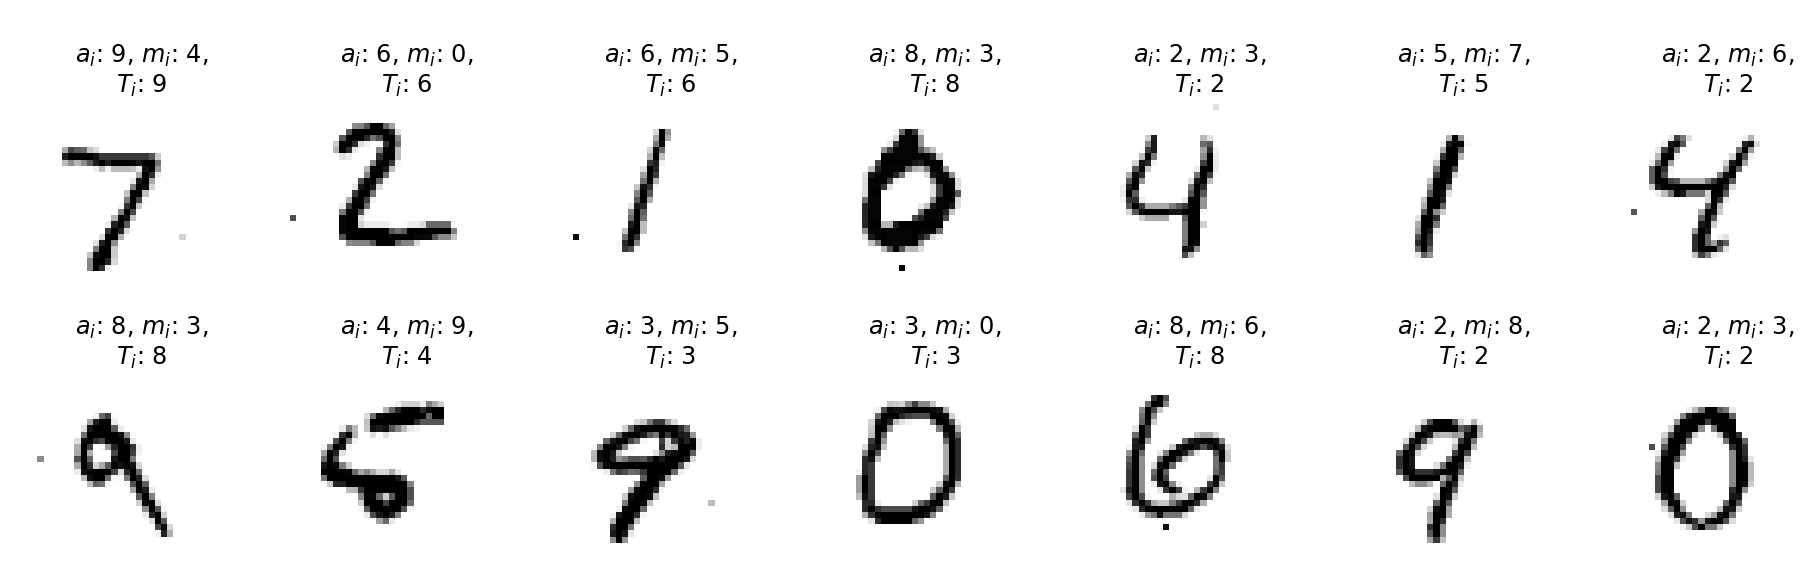

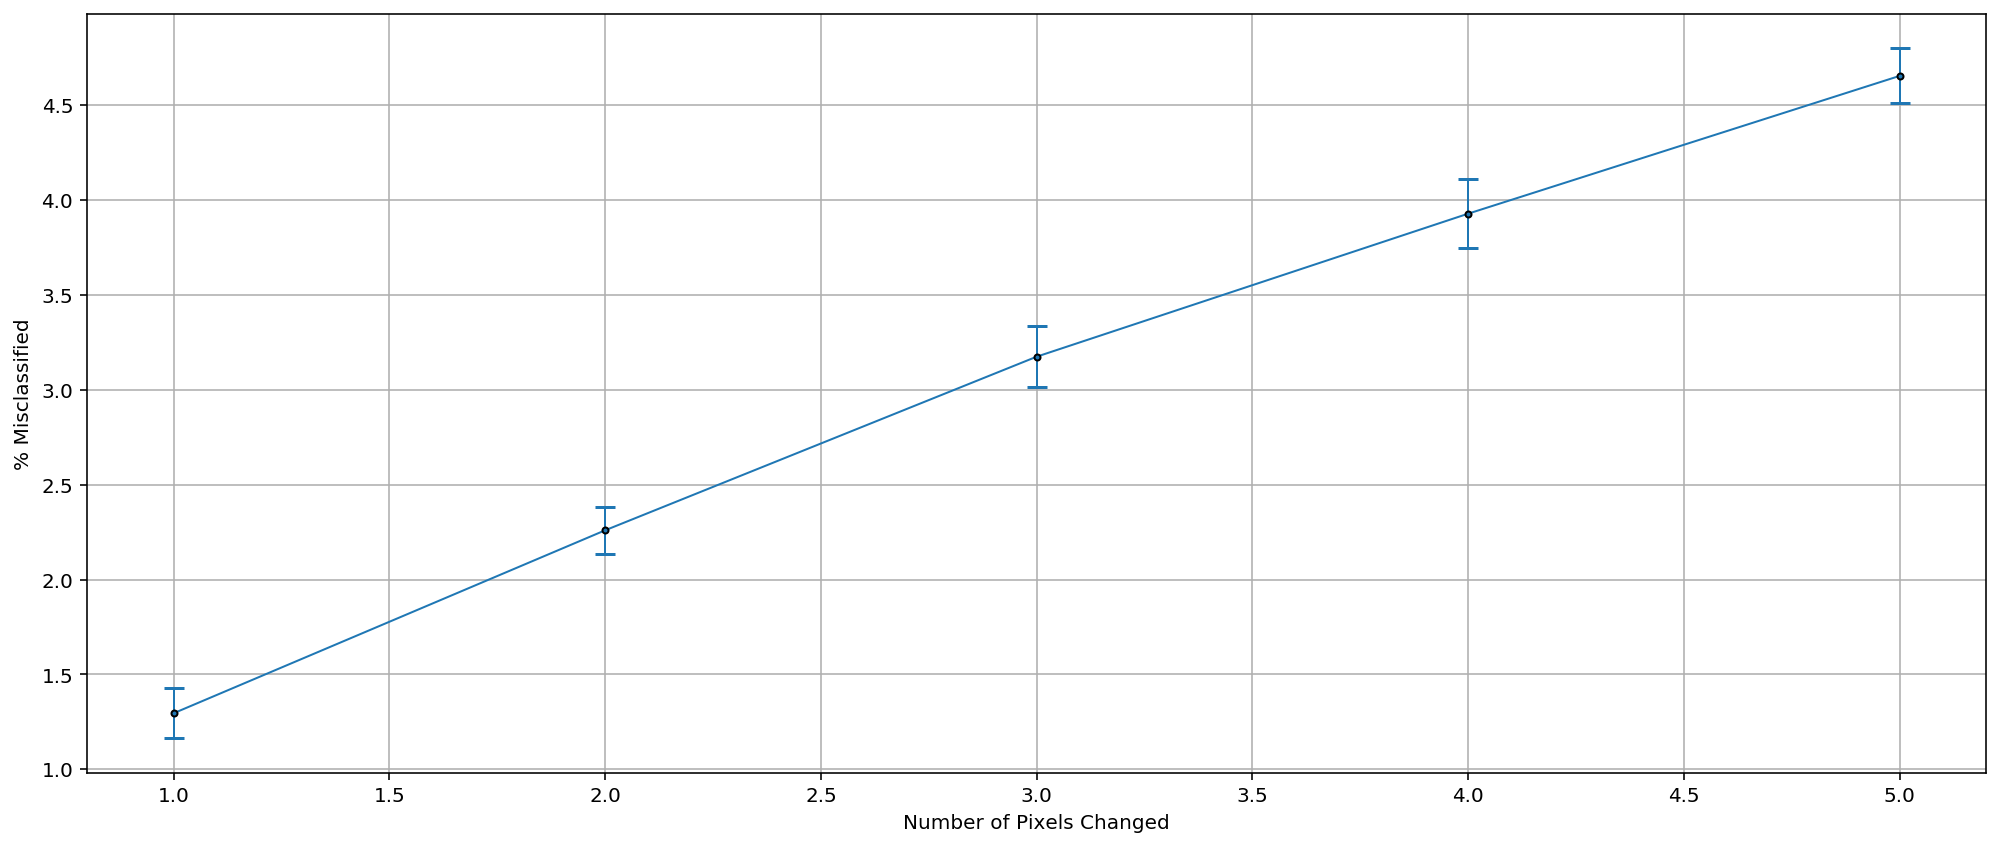

In [482]:
pixels_to_change = 1
Xcopy = change_pixel(Xtest, pixels_to_change=pixels_to_change)

diff_index, percent_diff = classified_diff(Xtest, Xcopy, Ttest)

print(f'''Total of {len(diff_index)} misclassified samples,
      with a {percent_diff:.3f}% difference from test by changing {pixels_to_change} pixel(s)''')

imshow(Xtest, Xcopy, Ttest, diff_index)

change_in_pixels_plot(Xtest, Ttest, end_pixel_val=5, trials_per_pixel=25)

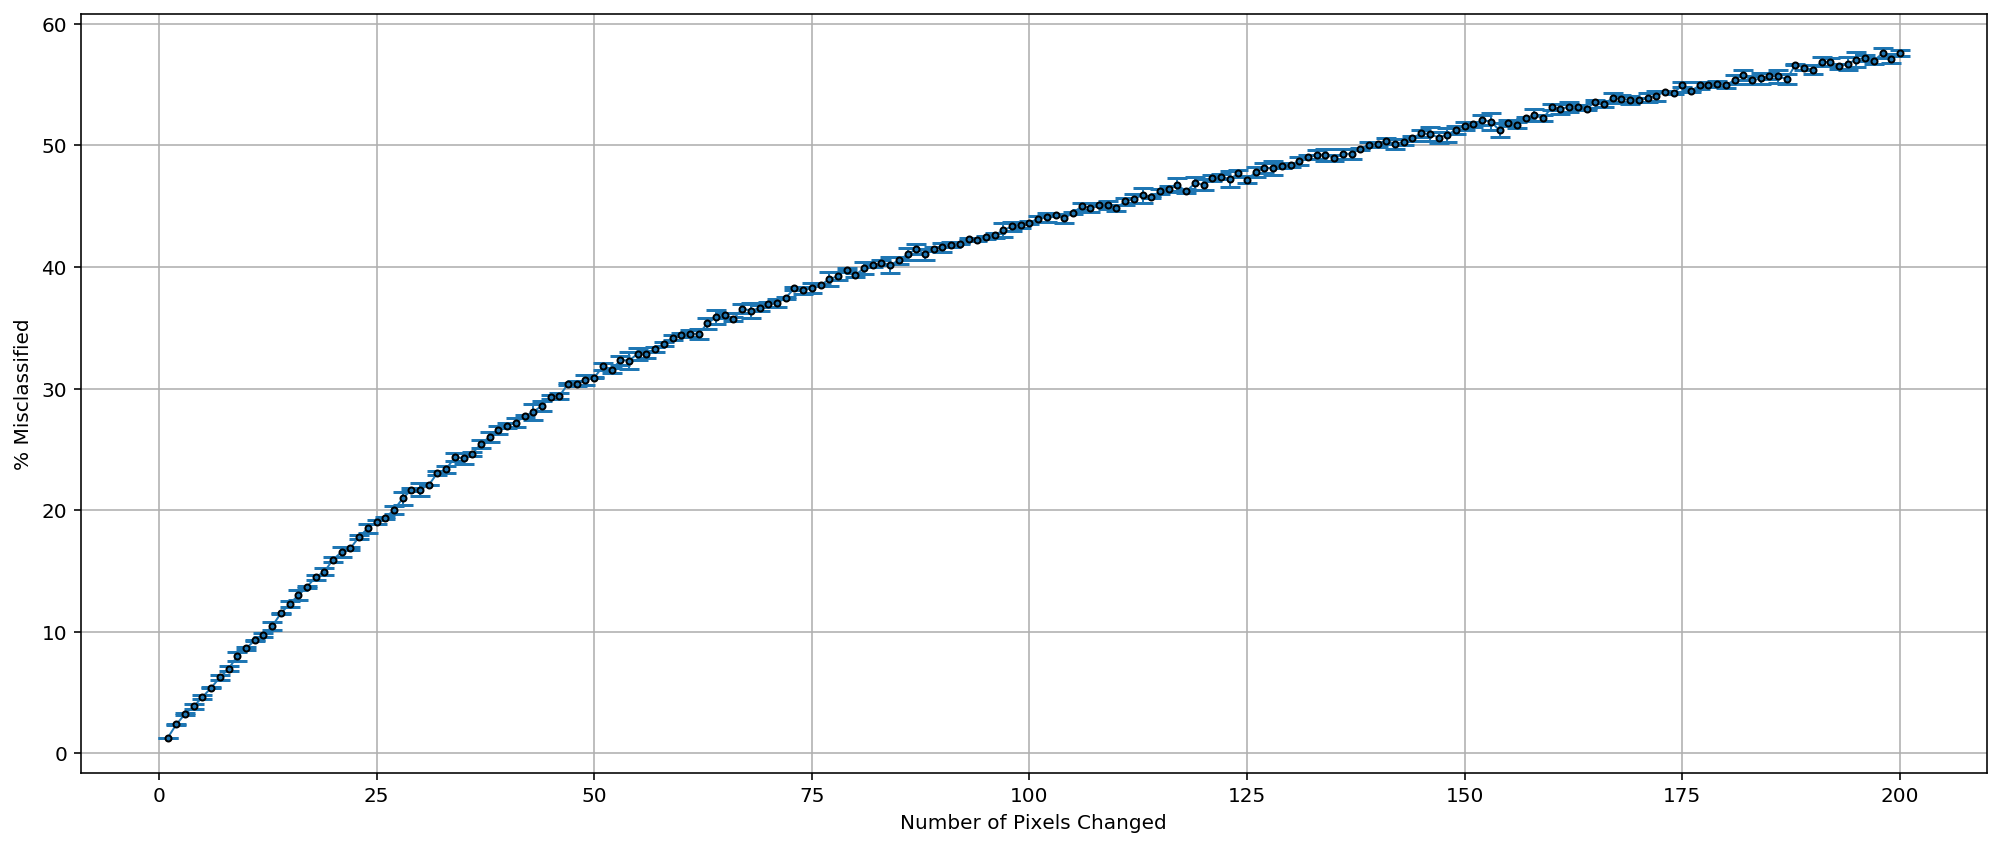

In [483]:
change_in_pixels_plot(Xtest, Ttest, end_pixel_val=5, trials_per_pixel=3, errorbar=False)